# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

## Caveats:

- The confirmed cases reported by each country are different from the number of infected people in each country.


- **The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infected people.** For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but the actual cases may not be rising as the same rate.


- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.


- The growth rate (or recent doubling time) changes with time, and will eventually fall to zero. So be cautious about extrapolating trends into the future based on current growth rates. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

## Global COVID-19 Analysis

In [3]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 3/18/20


,3/18/20
Country/Region,
China,81102
Italy,35713
Iran,17361
Spain,13910
Germany,12327
France,9105
"Korea, South",8413
US,7783
Switzerland,3028


## Curve Fitting Global COVID-19 Cases

In [4]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 81102
	Confirmed cases on 3/11/20 	 80921
	Ratio: 1.0
	Weekly increase: 0.2 %
	Daily increase: 0.0 % per day
	Doubling Time (represents recent growth): 2171.7 days

** Based on Logistic Fit**

	R^2: 0.995250391804
	Doubling Time (during middle of growth):  6.46 (± 0.55 ) days


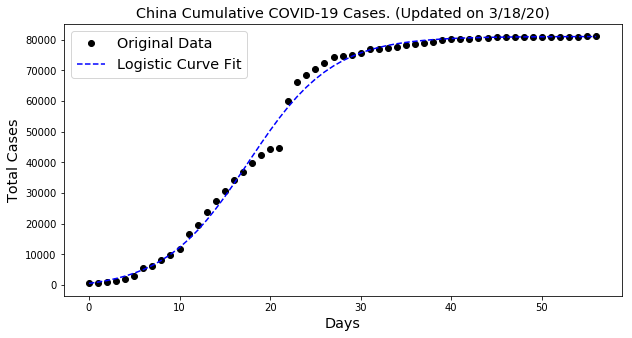



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 35713
	Confirmed cases on 3/11/20 	 12462
	Ratio: 2.87
	Weekly increase: 186.6 %
	Daily increase: 16.2 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Logistic Fit**

	R^2: 0.998147364491
	Doubling Time (during middle of growth):  6.38 (± 0.46 ) days

** Based on Exponential Fit **

	R^2: 0.994702687901
	Doubling Time (represents overall growth):  4.24 (± 0.19 ) days


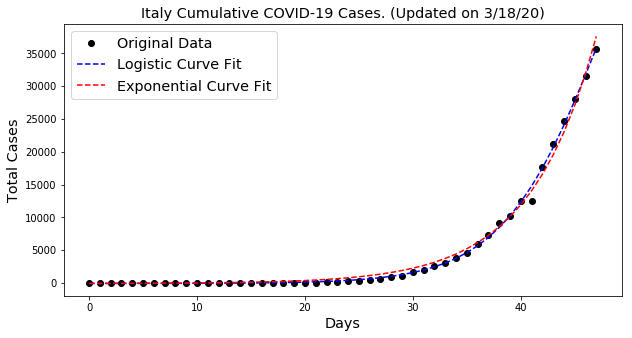



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 17361
	Confirmed cases on 3/11/20 	 9000
	Ratio: 1.93
	Weekly increase: 92.9 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.997072225231
	Doubling Time (during middle of growth):  6.88 (± 0.91 ) days


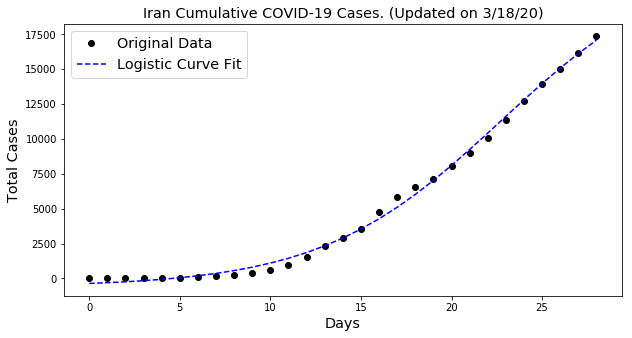



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 13910
	Confirmed cases on 3/11/20 	 2277
	Ratio: 6.11
	Weekly increase: 510.9 %
	Daily increase: 29.5 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Exponential Fit **

	R^2: 0.987221203357
	Doubling Time (represents overall growth):  2.88 (± 0.2 ) days


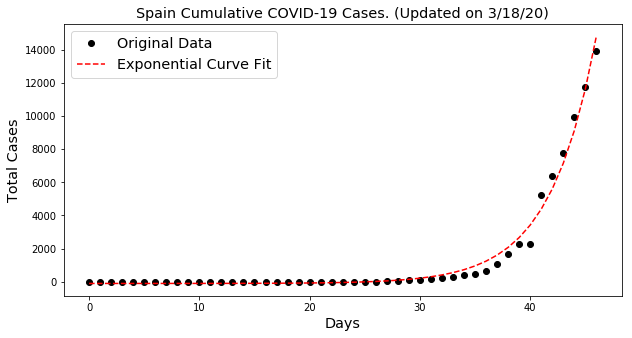



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 12327
	Confirmed cases on 3/11/20 	 1908
	Ratio: 6.46
	Weekly increase: 546.1 %
	Daily increase: 30.5 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Exponential Fit **

	R^2: 0.998215683835
	Doubling Time (represents overall growth):  2.68 (± 0.07 ) days


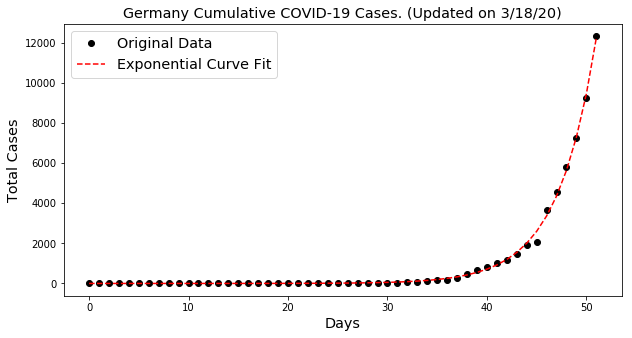



France

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 9105
	Confirmed cases on 3/11/20 	 2290
	Ratio: 3.98
	Weekly increase: 297.6 %
	Daily increase: 21.8 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Exponential Fit **

	R^2: 0.99398196604
	Doubling Time (represents overall growth):  3.33 (± 0.14 ) days


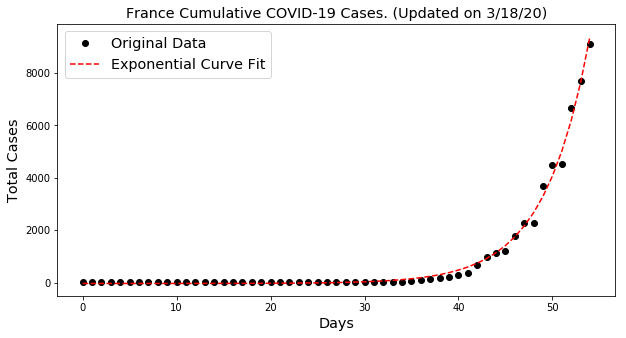



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 8413
	Confirmed cases on 3/11/20 	 7755
	Ratio: 1.08
	Weekly increase: 8.5 %
	Daily increase: 1.2 % per day
	Doubling Time (represents recent growth): 59.6 days

** Based on Logistic Fit**

	R^2: 0.999415612508
	Doubling Time (during middle of growth):  4.15 (± 0.13 ) days


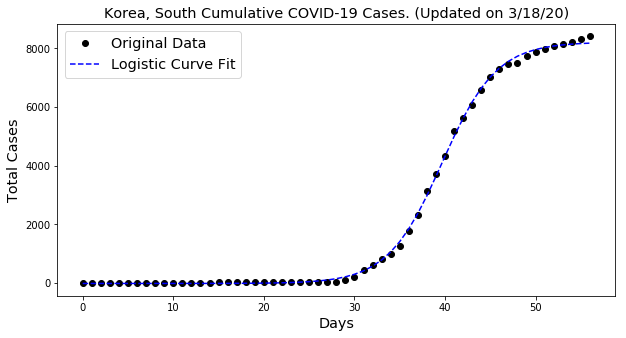



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 7783
	Confirmed cases on 3/11/20 	 1281
	Ratio: 6.08
	Weekly increase: 507.6 %
	Daily increase: 29.4 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Exponential Fit **

	R^2: 0.998578801135
	Doubling Time (represents overall growth):  2.61 (± 0.05 ) days


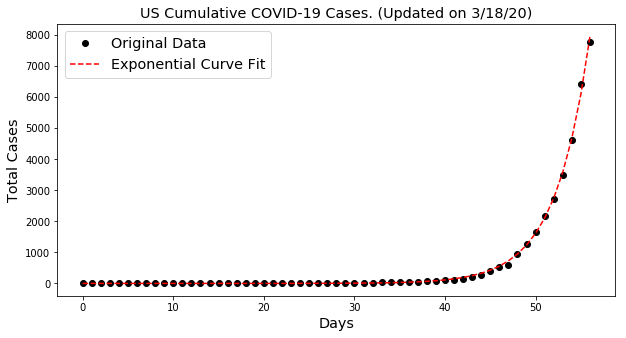



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 3028
	Confirmed cases on 3/11/20 	 652
	Ratio: 4.64
	Weekly increase: 364.4 %
	Daily increase: 24.5 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.989606293189
	Doubling Time (during middle of growth):  3.61 (± 0.9 ) days

** Based on Exponential Fit **

	R^2: 0.981307398333
	Doubling Time (represents overall growth):  3.47 (± 0.52 ) days


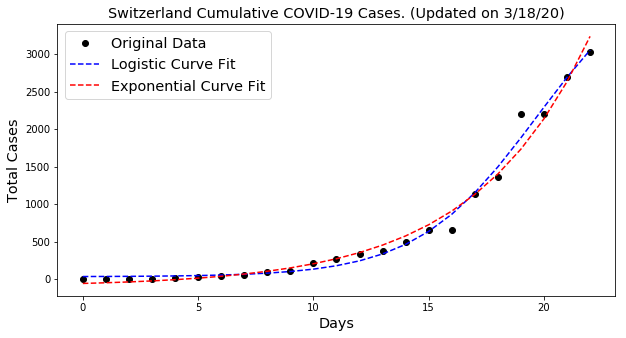



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 2642
	Confirmed cases on 3/11/20 	 459
	Ratio: 5.76
	Weekly increase: 475.6 %
	Daily increase: 28.4 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Exponential Fit **

	R^2: 0.994808243112
	Doubling Time (represents overall growth):  2.83 (± 0.12 ) days


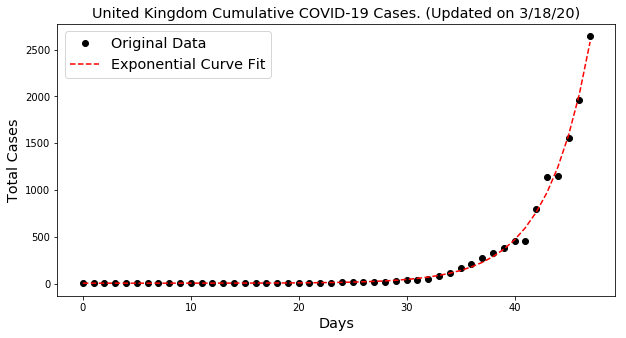



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 2058
	Confirmed cases on 3/11/20 	 503
	Ratio: 4.09
	Weekly increase: 309.1 %
	Daily increase: 22.3 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Logistic Fit**

	R^2: 0.997585803435
	Doubling Time (during middle of growth):  6.16 (± 1.24 ) days

** Based on Exponential Fit **

	R^2: 0.997259619687
	Doubling Time (represents overall growth):  3.63 (± 0.23 ) days


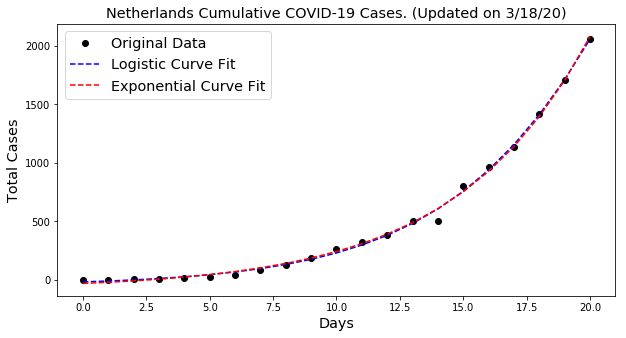



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 1646
	Confirmed cases on 3/11/20 	 246
	Ratio: 6.69
	Weekly increase: 569.1 %
	Daily increase: 31.2 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.998451211346
	Doubling Time (during middle of growth):  4.1 (± 0.45 ) days

** Based on Exponential Fit **

	R^2: 0.996264851531
	Doubling Time (represents overall growth):  2.81 (± 0.17 ) days


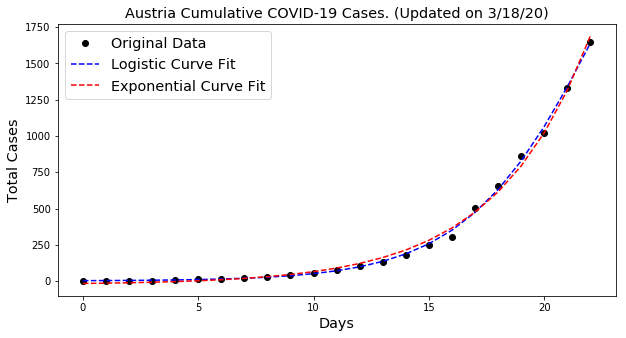



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 1550
	Confirmed cases on 3/11/20 	 598
	Ratio: 2.59
	Weekly increase: 159.2 %
	Daily increase: 14.6 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Logistic Fit**

	R^2: 0.996899495428
	Doubling Time (during middle of growth):  2.98 (± 0.36 ) days

** Based on Exponential Fit **

	R^2: 0.96220799866
	Doubling Time (represents overall growth):  4.55 (± 1.22 ) days


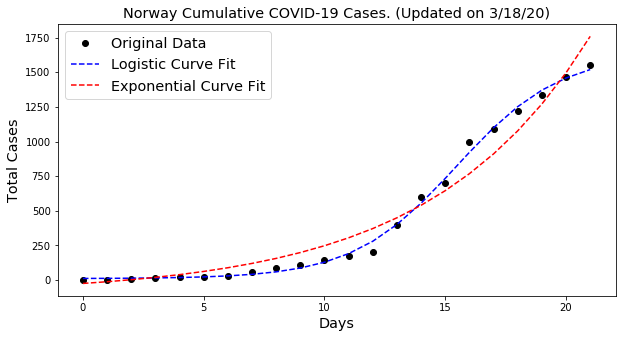



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 1486
	Confirmed cases on 3/11/20 	 314
	Ratio: 4.73
	Weekly increase: 373.2 %
	Daily increase: 24.9 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Exponential Fit **

	R^2: 0.993026564948
	Doubling Time (represents overall growth):  3.27 (± 0.18 ) days


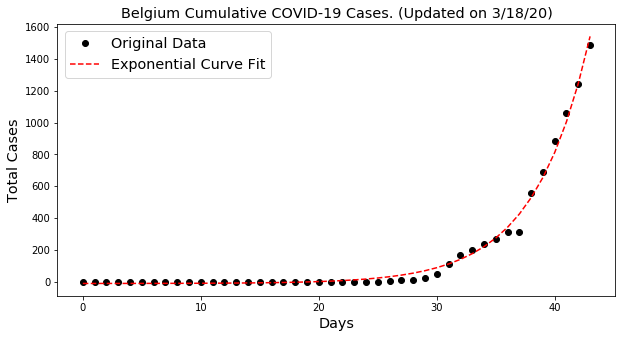



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 1279
	Confirmed cases on 3/11/20 	 500
	Ratio: 2.56
	Weekly increase: 155.8 %
	Daily increase: 14.4 % per day
	Doubling Time (represents recent growth): 5.2 days

** Based on Logistic Fit**

	R^2: 0.99850241558
	Doubling Time (during middle of growth):  3.33 (± 0.19 ) days

** Based on Exponential Fit **

	R^2: 0.967552765866
	Doubling Time (represents overall growth):  4.35 (± 0.5 ) days


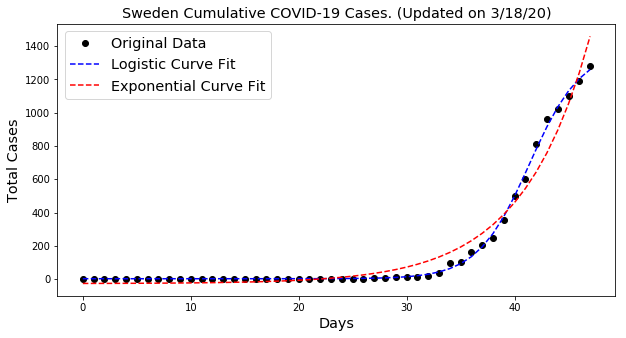



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 1115
	Confirmed cases on 3/11/20 	 444
	Ratio: 2.51
	Weekly increase: 151.1 %
	Daily increase: 14.1 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Logistic Fit**

	R^2: 0.992241681309
	Doubling Time (during middle of growth):  1.94 (± 0.38 ) days


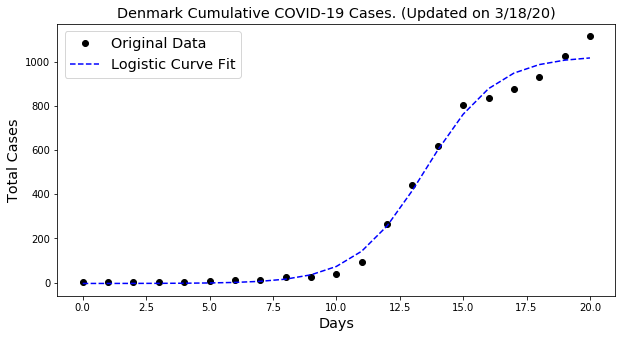



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 889
	Confirmed cases on 3/11/20 	 639
	Ratio: 1.39
	Weekly increase: 39.1 %
	Daily increase: 4.8 % per day
	Doubling Time (represents recent growth): 14.7 days

** Based on Logistic Fit**

	R^2: 0.997382932577
	Doubling Time (during middle of growth):  11.47 (± 0.94 ) days

** Based on Exponential Fit **

	R^2: 0.991795952648
	Doubling Time (represents overall growth):  9.84 (± 0.63 ) days


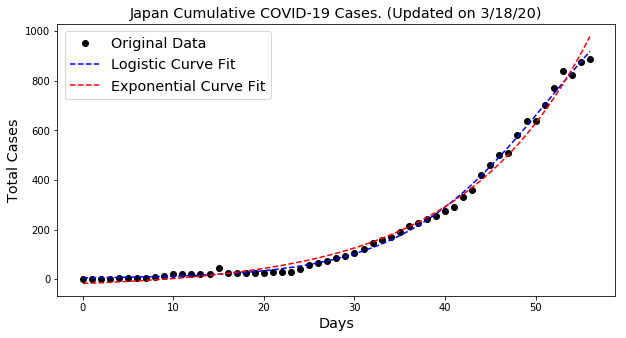



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 790
	Confirmed cases on 3/11/20 	 149
	Ratio: 5.3
	Weekly increase: 430.2 %
	Daily increase: 26.9 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Exponential Fit **

	R^2: 0.985820439215
	Doubling Time (represents overall growth):  2.73 (± 0.18 ) days


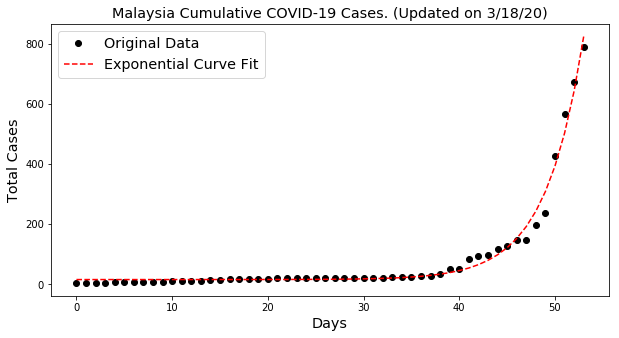



Cruise Ship

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 712
	Confirmed cases on 3/11/20 	 696
	Ratio: 1.02
	Weekly increase: 2.3 %
	Daily increase: 0.3 % per day
	Doubling Time (represents recent growth): 213.5 days

** Based on Logistic Fit**

	R^2: 0.995665788717
	Doubling Time (during middle of growth):  2.69 (± 0.28 ) days


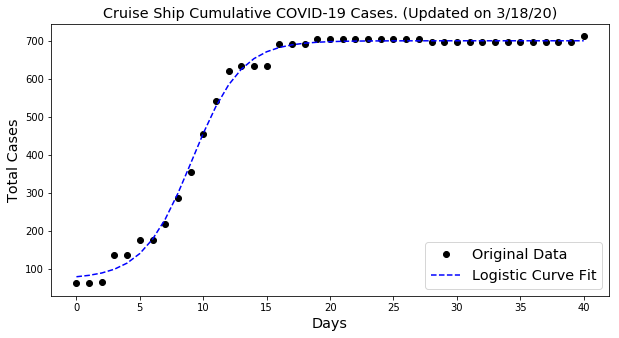



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 657
	Confirmed cases on 3/11/20 	 108
	Ratio: 6.08
	Weekly increase: 508.3 %
	Daily increase: 29.4 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Exponential Fit **

	R^2: 0.992496120099
	Doubling Time (represents overall growth):  2.55 (± 0.13 ) days


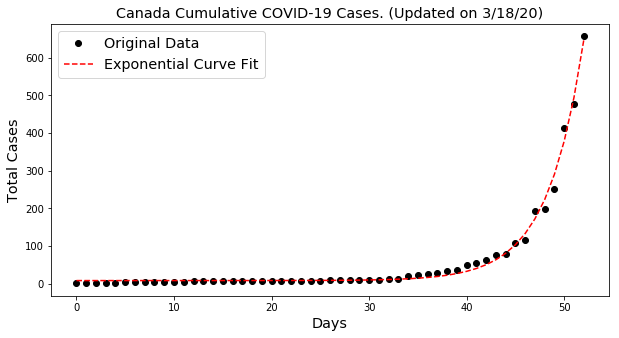



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 568
	Confirmed cases on 3/11/20 	 128
	Ratio: 4.44
	Weekly increase: 343.8 %
	Daily increase: 23.7 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Exponential Fit **

	R^2: 0.997034422169
	Doubling Time (represents overall growth):  3.13 (± 0.1 ) days


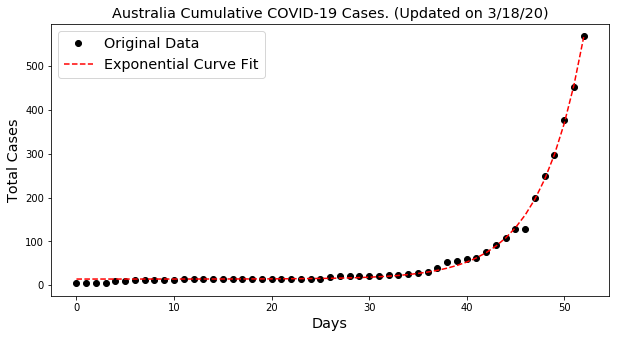



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 464
	Confirmed cases on 3/11/20 	 91
	Ratio: 5.1
	Weekly increase: 409.9 %
	Daily increase: 26.2 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Logistic Fit**

	R^2: 0.997336126177
	Doubling Time (during middle of growth):  3.81 (± 0.66 ) days

** Based on Exponential Fit **

	R^2: 0.993733704432
	Doubling Time (represents overall growth):  3.01 (± 0.32 ) days


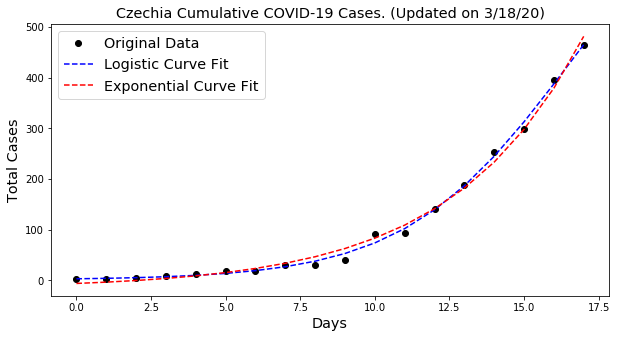



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 452
	Confirmed cases on 3/11/20 	 262
	Ratio: 1.73
	Weekly increase: 72.5 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

** Based on Logistic Fit**

	R^2: 0.971430408591
	Doubling Time (during middle of growth):  1.67 (± 0.68 ) days


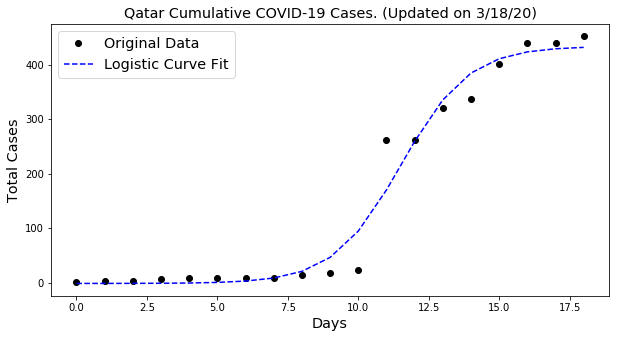



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 448
	Confirmed cases on 3/11/20 	 59
	Ratio: 7.59
	Weekly increase: 659.3 %
	Daily increase: 33.6 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.992705044779
	Doubling Time (during middle of growth):  2.13 (± 0.49 ) days

** Based on Exponential Fit **

	R^2: 0.972180906762
	Doubling Time (represents overall growth):  2.8 (± 0.65 ) days


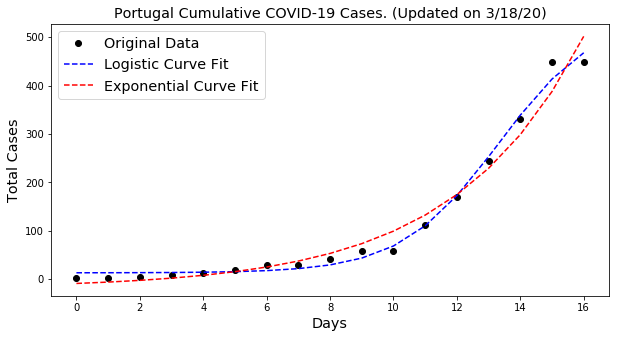



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 433
	Confirmed cases on 3/11/20 	 109
	Ratio: 3.97
	Weekly increase: 297.2 %
	Daily increase: 21.8 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Logistic Fit**

	R^2: 0.995054645296
	Doubling Time (during middle of growth):  7.09 (± 1.5 ) days

** Based on Exponential Fit **

	R^2: 0.995054645448
	Doubling Time (represents overall growth):  3.54 (± 0.23 ) days


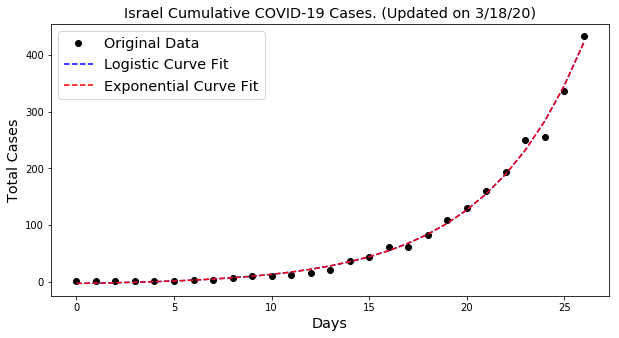



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 418
	Confirmed cases on 3/11/20 	 99
	Ratio: 4.22
	Weekly increase: 322.2 %
	Daily increase: 22.8 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Logistic Fit**

	R^2: 0.984309715819
	Doubling Time (during middle of growth):  3.74 (± 1.18 ) days

** Based on Exponential Fit **

	R^2: 0.974337100295
	Doubling Time (represents overall growth):  4.09 (± 0.82 ) days


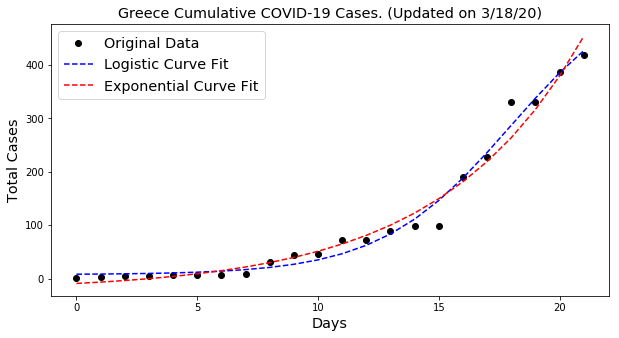



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 372
	Confirmed cases on 3/11/20 	 38
	Ratio: 9.79
	Weekly increase: 878.9 %
	Daily increase: 38.5 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.977628216911
	Doubling Time (during middle of growth):  4.3 (± 1.99 ) days

** Based on Exponential Fit **

	R^2: 0.976555668559
	Doubling Time (represents overall growth):  2.67 (± 0.43 ) days


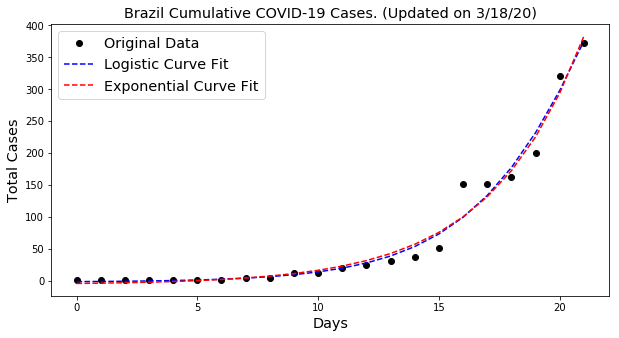



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 336
	Confirmed cases on 3/11/20 	 59
	Ratio: 5.69
	Weekly increase: 469.5 %
	Daily increase: 28.2 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Exponential Fit **

	R^2: 0.958836971898
	Doubling Time (represents overall growth):  3.24 (± 0.4 ) days


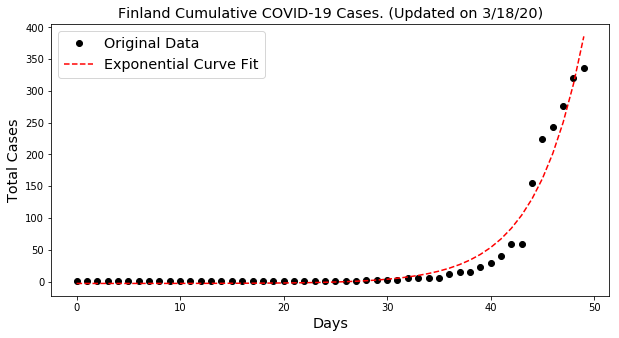



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 313
	Confirmed cases on 3/11/20 	 178
	Ratio: 1.76
	Weekly increase: 75.8 %
	Daily increase: 8.4 % per day
	Doubling Time (represents recent growth): 8.6 days

** Based on Logistic Fit**

	R^2: 0.964563089257
	Doubling Time (during middle of growth):  28.15 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.964563090354
	Doubling Time (represents overall growth):  14.08 (± 2.4 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


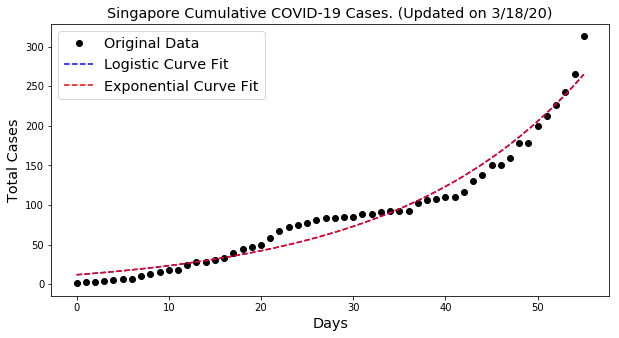



Pakistan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 299
	Confirmed cases on 3/11/20 	 19
	Ratio: 15.74
	Weekly increase: 1473.7 %
	Daily increase: 48.2 % per day
	Doubling Time (represents recent growth): 1.8 days

** Based on Exponential Fit **

	R^2: 0.977568873648
	Doubling Time (represents overall growth):  1.48 (± 0.22 ) days


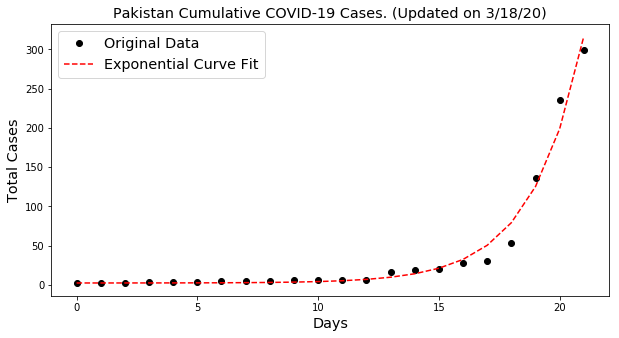



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 292
	Confirmed cases on 3/11/20 	 43
	Ratio: 6.79
	Weekly increase: 579.1 %
	Daily increase: 31.5 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Logistic Fit**

	R^2: 0.990358077868
	Doubling Time (during middle of growth):  5.2 (± 2.21 ) days

** Based on Exponential Fit **

	R^2: 0.990303998072
	Doubling Time (represents overall growth):  2.77 (± 0.33 ) days


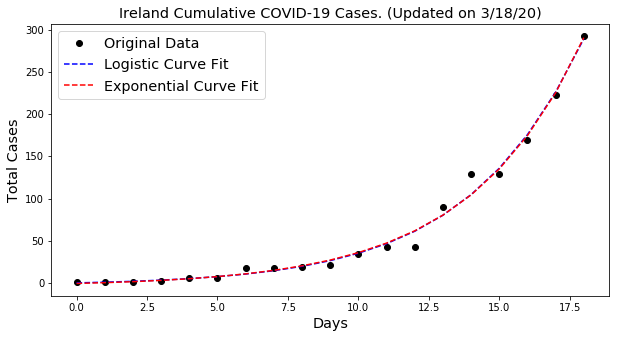



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 275
	Confirmed cases on 3/11/20 	 57
	Ratio: 4.82
	Weekly increase: 382.5 %
	Daily increase: 25.2 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.999033014716
	Doubling Time (during middle of growth):  2.08 (± 0.19 ) days

** Based on Exponential Fit **

	R^2: 0.957983259893
	Doubling Time (represents overall growth):  5.72 (± 3.53 ) days


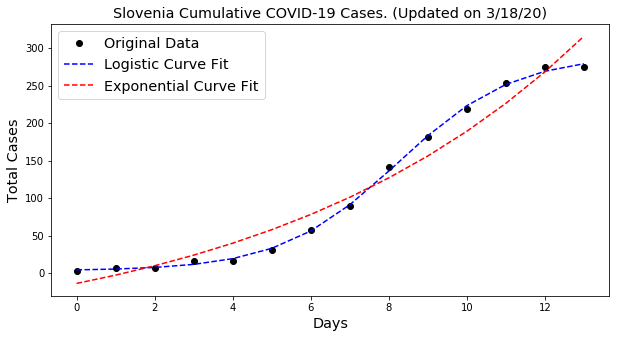



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 260
	Confirmed cases on 3/11/20 	 45
	Ratio: 5.78
	Weekly increase: 477.8 %
	Daily increase: 28.5 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Logistic Fit**

	R^2: 0.986884044793
	Doubling Time (during middle of growth):  4.44 (± 1.53 ) days

** Based on Exponential Fit **

	R^2: 0.98513170998
	Doubling Time (represents overall growth):  2.99 (± 0.39 ) days


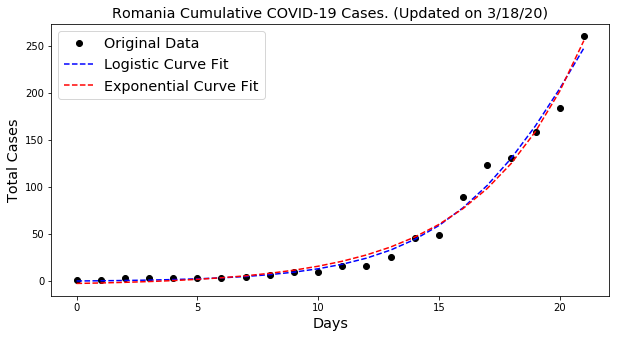



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 258
	Confirmed cases on 3/11/20 	 16
	Ratio: 16.12
	Weekly increase: 1512.5 %
	Daily increase: 48.8 % per day
	Doubling Time (represents recent growth): 1.7 days

** Based on Logistic Fit**

	R^2: 0.993776553801
	Doubling Time (during middle of growth):  1.64 (± 0.29 ) days

** Based on Exponential Fit **

	R^2: 0.951736837785
	Doubling Time (represents overall growth):  2.84 (± 0.71 ) days


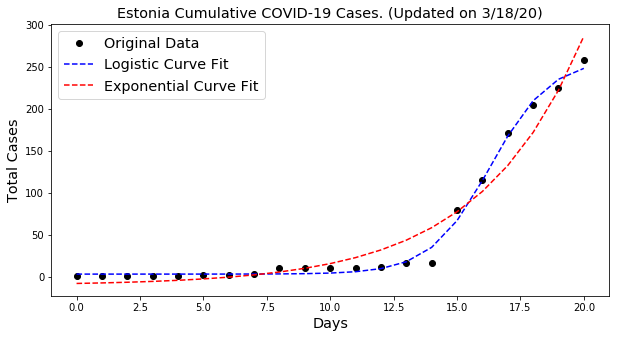



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 256
	Confirmed cases on 3/11/20 	 195
	Ratio: 1.31
	Weekly increase: 31.3 %
	Daily increase: 4.0 % per day
	Doubling Time (represents recent growth): 17.8 days

** Based on Logistic Fit**

	R^2: 0.967543952588
	Doubling Time (during middle of growth):  3.37 (± 1.25 ) days


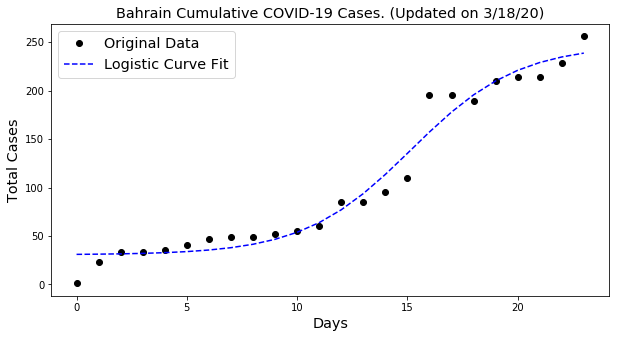



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 251
	Confirmed cases on 3/11/20 	 31
	Ratio: 8.1
	Weekly increase: 709.7 %
	Daily increase: 34.8 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.993248305374
	Doubling Time (during middle of growth):  2.91 (± 0.82 ) days

** Based on Exponential Fit **

	R^2: 0.984414624423
	Doubling Time (represents overall growth):  3.01 (± 0.62 ) days


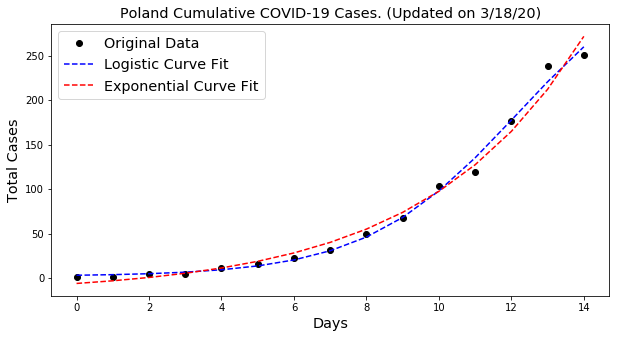



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 250
	Confirmed cases on 3/11/20 	 85
	Ratio: 2.94
	Weekly increase: 194.1 %
	Daily increase: 16.7 % per day
	Doubling Time (represents recent growth): 4.5 days

** Based on Logistic Fit**

	R^2: 0.993370462243
	Doubling Time (during middle of growth):  9.47 (± 5.64 ) days

** Based on Exponential Fit **

	R^2: 0.993228415952
	Doubling Time (represents overall growth):  5.87 (± 0.86 ) days


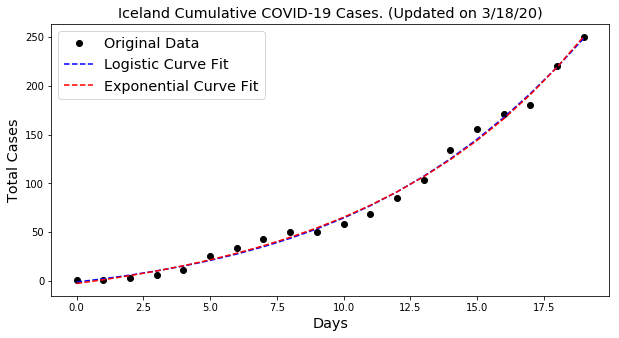



Chile

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 238
	Confirmed cases on 3/11/20 	 23
	Ratio: 10.35
	Weekly increase: 934.8 %
	Daily increase: 39.6 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.990388980492
	Doubling Time (during middle of growth):  2.1 (± 0.62 ) days

** Based on Exponential Fit **

	R^2: 0.97987245493
	Doubling Time (represents overall growth):  2.14 (± 0.4 ) days


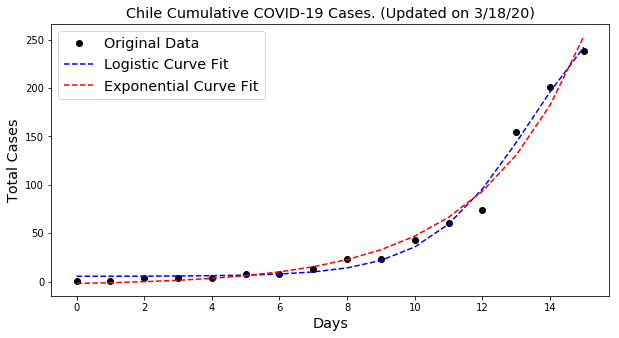



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 227
	Confirmed cases on 3/11/20 	 34
	Ratio: 6.68
	Weekly increase: 567.6 %
	Daily increase: 31.2 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.992169335358
	Doubling Time (during middle of growth):  4.51 (± 1.69 ) days

** Based on Exponential Fit **

	R^2: 0.991153032345
	Doubling Time (represents overall growth):  2.97 (± 0.39 ) days


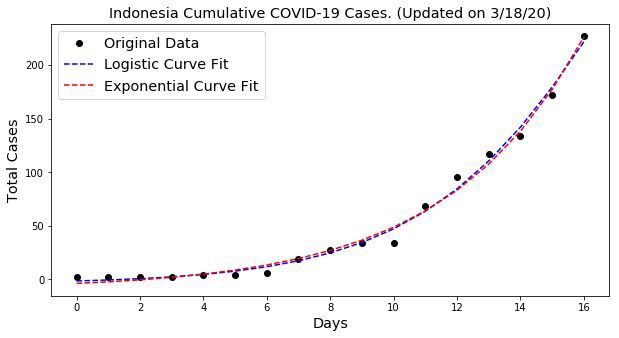



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 212
	Confirmed cases on 3/11/20 	 59
	Ratio: 3.59
	Weekly increase: 259.3 %
	Daily increase: 20.0 % per day
	Doubling Time (represents recent growth): 3.8 days


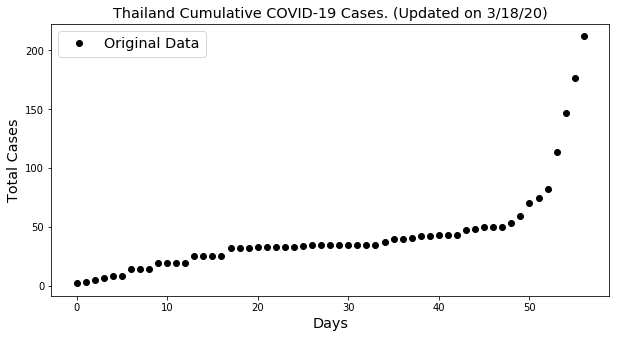



Luxembourg

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 203
	Confirmed cases on 3/11/20 	 7
	Ratio: 29.0
	Weekly increase: 2800.0 %
	Daily increase: 61.8 % per day
	Doubling Time (represents recent growth): 1.4 days

** Based on Exponential Fit **

	R^2: 0.992507273318
	Doubling Time (represents overall growth):  1.72 (± 0.16 ) days


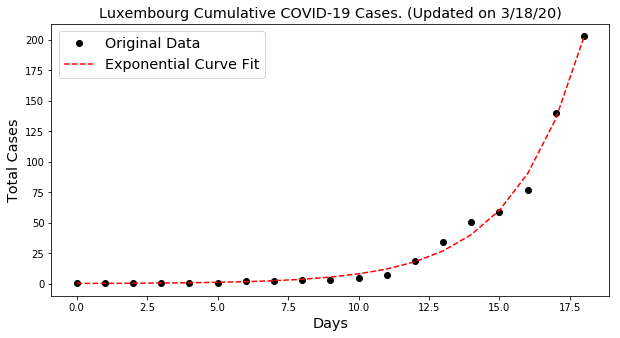



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 202
	Confirmed cases on 3/11/20 	 49
	Ratio: 4.12
	Weekly increase: 312.2 %
	Daily increase: 22.4 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Exponential Fit **

	R^2: 0.977062067002
	Doubling Time (represents overall growth):  3.07 (± 0.28 ) days


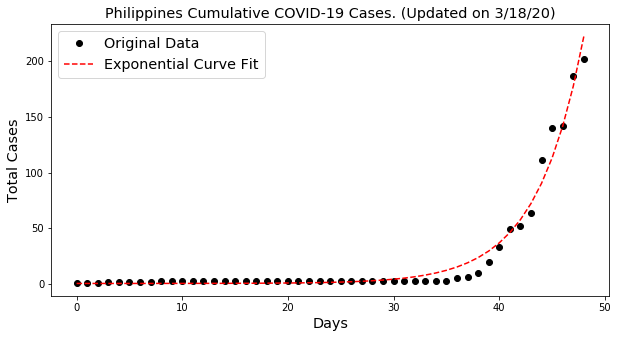



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 196
	Confirmed cases on 3/11/20 	 60
	Ratio: 3.27
	Weekly increase: 226.7 %
	Daily increase: 18.4 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.980386236378
	Doubling Time (during middle of growth):  5.91 (± 1.83 ) days

** Based on Exponential Fit **

	R^2: 0.978015691559
	Doubling Time (represents overall growth):  3.89 (± 0.46 ) days


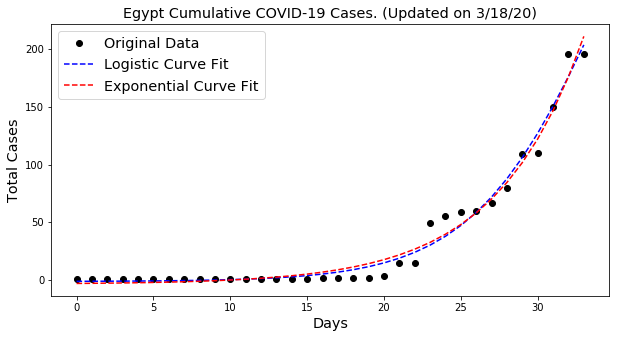



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 171
	Confirmed cases on 3/11/20 	 21
	Ratio: 8.14
	Weekly increase: 714.3 %
	Daily increase: 34.9 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.976633096232
	Doubling Time (during middle of growth):  3.07 (± 1.37 ) days

** Based on Exponential Fit **

	R^2: 0.961999031811
	Doubling Time (represents overall growth):  3.97 (± 1.31 ) days


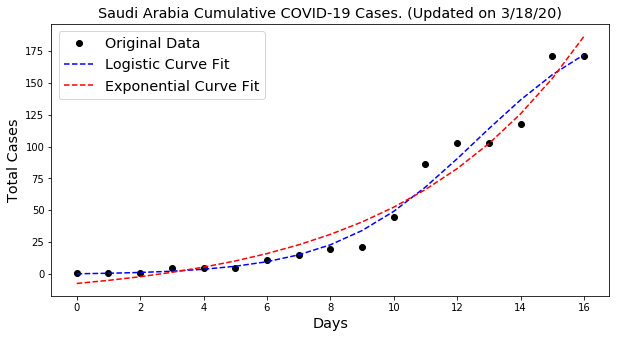



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 164
	Confirmed cases on 3/11/20 	 71
	Ratio: 2.31
	Weekly increase: 131.0 %
	Daily increase: 12.7 % per day
	Doubling Time (represents recent growth): 5.8 days

** Based on Logistic Fit**

	R^2: 0.988479635234
	Doubling Time (during middle of growth):  15.92 (± 10.51 ) days

** Based on Exponential Fit **

	R^2: 0.988479635899
	Doubling Time (represents overall growth):  7.96 (± 1.51 ) days


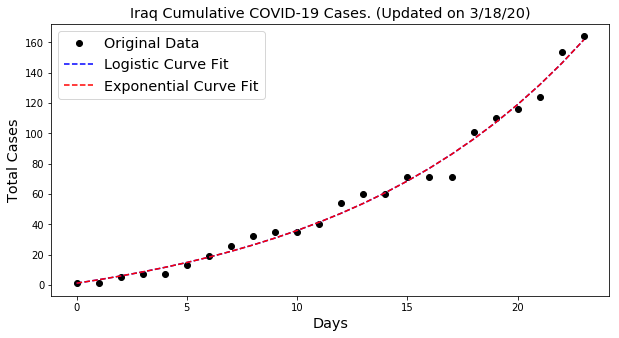



India

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 156
	Confirmed cases on 3/11/20 	 62
	Ratio: 2.52
	Weekly increase: 151.6 %
	Daily increase: 14.1 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Exponential Fit **

	R^2: 0.986194950987
	Doubling Time (represents overall growth):  4.79 (± 0.35 ) days


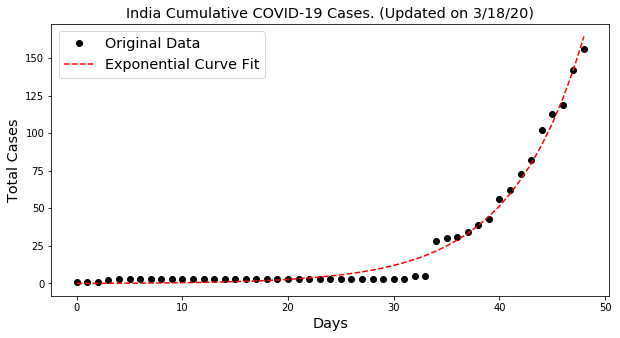



Russia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 147
	Confirmed cases on 3/11/20 	 20
	Ratio: 7.35
	Weekly increase: 635.0 %
	Daily increase: 33.0 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Exponential Fit **

	R^2: 0.995386302186
	Doubling Time (represents overall growth):  2.68 (± 0.11 ) days


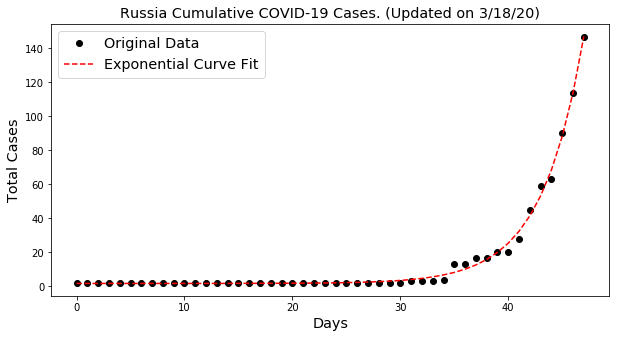



Peru

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 145
	Confirmed cases on 3/11/20 	 11
	Ratio: 13.18
	Weekly increase: 1218.2 %
	Daily increase: 44.5 % per day
	Doubling Time (represents recent growth): 1.9 days

** Based on Logistic Fit**

	R^2: 0.990763153364
	Doubling Time (during middle of growth):  2.43 (± 0.93 ) days

** Based on Exponential Fit **

	R^2: 0.986142896377
	Doubling Time (represents overall growth):  2.12 (± 0.41 ) days


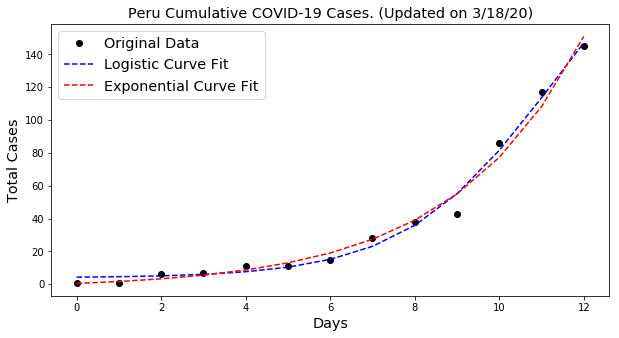



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 142
	Confirmed cases on 3/11/20 	 72
	Ratio: 1.97
	Weekly increase: 97.2 %
	Daily increase: 10.2 % per day
	Doubling Time (represents recent growth): 7.1 days


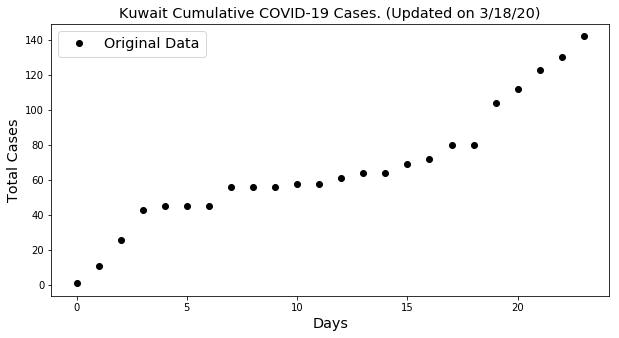



Lebanon

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 133
	Confirmed cases on 3/11/20 	 61
	Ratio: 2.18
	Weekly increase: 118.0 %
	Daily increase: 11.8 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.989928535194
	Doubling Time (during middle of growth):  5.26 (± 1.23 ) days

** Based on Exponential Fit **

	R^2: 0.981320050594
	Doubling Time (represents overall growth):  5.63 (± 0.91 ) days


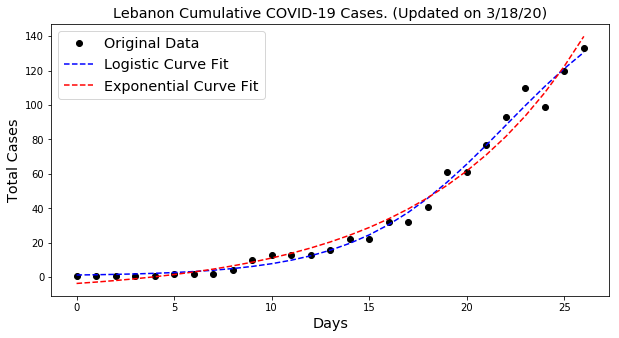



San Marino

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 119
	Confirmed cases on 3/11/20 	 62
	Ratio: 1.92
	Weekly increase: 91.9 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.99334013321
	Doubling Time (during middle of growth):  5.52 (± 1.42 ) days

** Based on Exponential Fit **

	R^2: 0.985070550099
	Doubling Time (represents overall growth):  9.36 (± 2.81 ) days


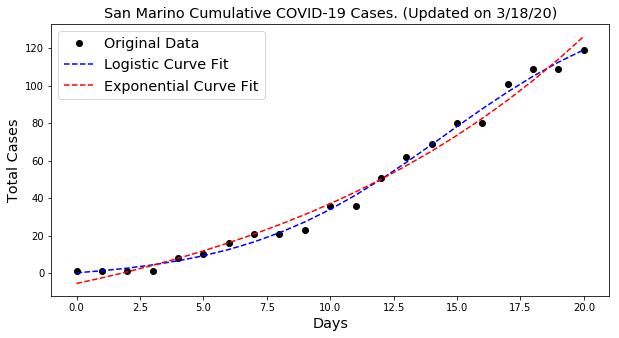



South Africa

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 116
	Confirmed cases on 3/11/20 	 13
	Ratio: 8.92
	Weekly increase: 792.3 %
	Daily increase: 36.7 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.966678797572
	Doubling Time (during middle of growth):  4.96 (± 2.79 ) days

** Based on Exponential Fit **

	R^2: 0.966678798218
	Doubling Time (represents overall growth):  2.48 (± 0.74 ) days


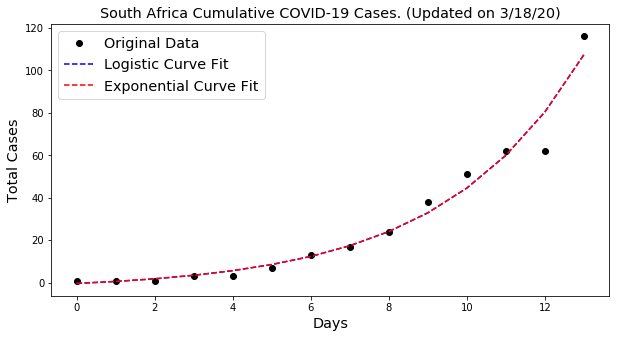



United Arab Emirates

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 113
	Confirmed cases on 3/11/20 	 74
	Ratio: 1.53
	Weekly increase: 52.7 %
	Daily increase: 6.2 % per day
	Doubling Time (represents recent growth): 11.5 days

** Based on Logistic Fit**

	R^2: 0.985526843688
	Doubling Time (during middle of growth):  6.04 (± 1.05 ) days

** Based on Exponential Fit **

	R^2: 0.969744178309
	Doubling Time (represents overall growth):  7.16 (± 0.87 ) days


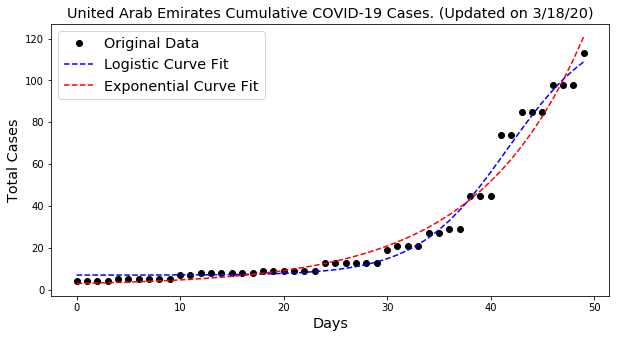



Ecuador

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 111
	Confirmed cases on 3/11/20 	 17
	Ratio: 6.53
	Weekly increase: 552.9 %
	Daily increase: 30.7 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Exponential Fit **

	R^2: 0.976583141729
	Doubling Time (represents overall growth):  1.1 (± 0.19 ) days


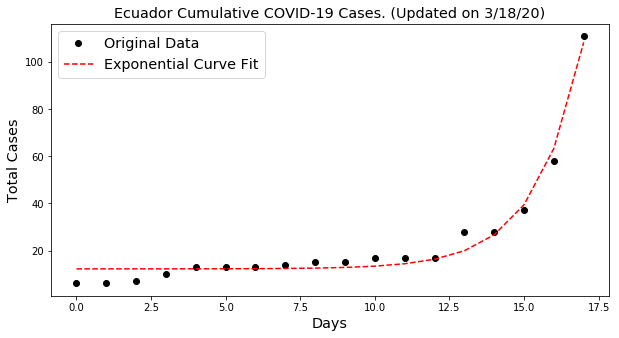



Slovakia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 105
	Confirmed cases on 3/11/20 	 10
	Ratio: 10.5
	Weekly increase: 950.0 %
	Daily increase: 39.9 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.983092803245
	Doubling Time (during middle of growth):  5.05 (± 5.01 ) days

** Based on Exponential Fit **

	R^2: 0.982684795486
	Doubling Time (represents overall growth):  3.35 (± 0.94 ) days


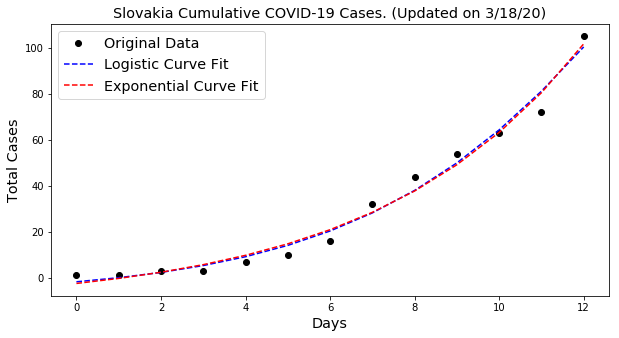



Taiwan*

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 100
	Confirmed cases on 3/11/20 	 48
	Ratio: 2.08
	Weekly increase: 108.3 %
	Daily increase: 11.1 % per day
	Doubling Time (represents recent growth): 6.6 days


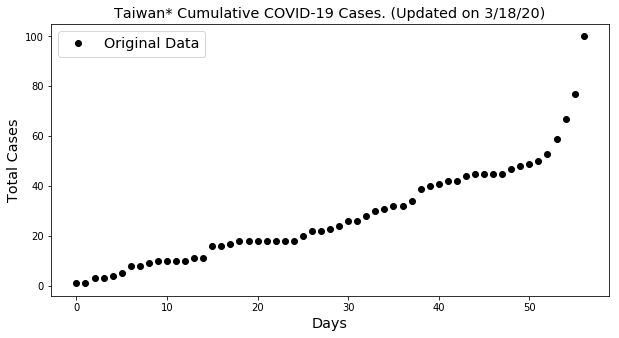

In [5]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


               Countries  Inferred Doubling Time  Recent Doubling Time
0                  China                     6.5                2171.7
1                  Italy                     6.4                   4.6
2                   Iran                     6.9                   7.4
3                  Spain                     2.9                   2.7
4                Germany                     2.7                   2.6
5                 France                     3.3                   3.5
6           Korea, South                     4.1                  59.6
7                     US                     2.6                   2.7
8            Switzerland                     3.6                   3.2
9         United Kingdom                     2.8                   2.8
10         

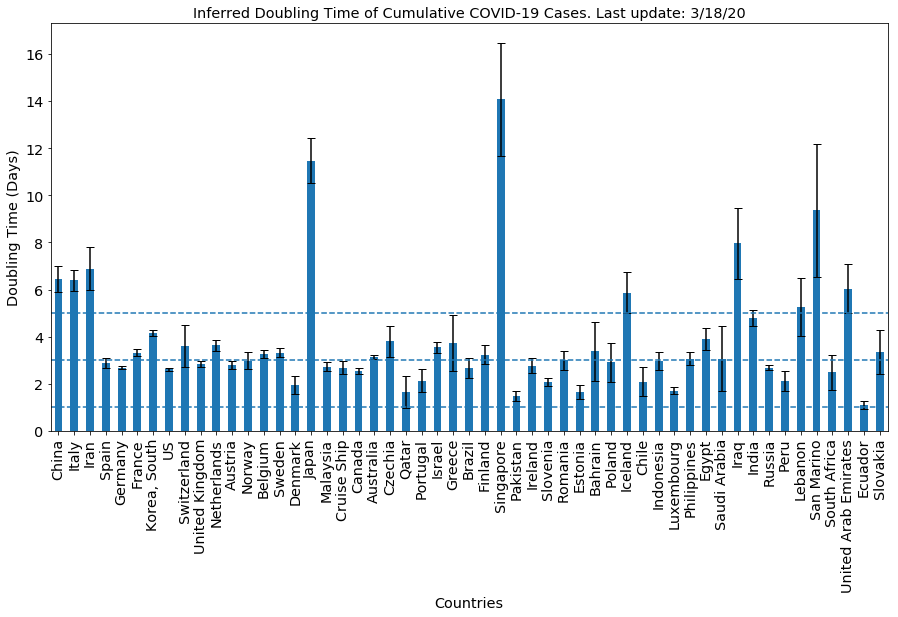

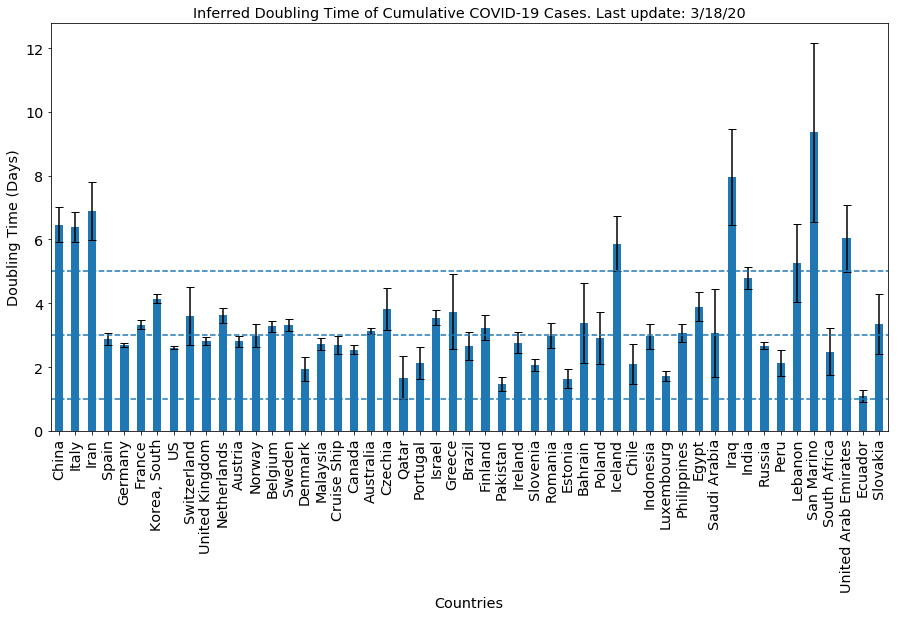

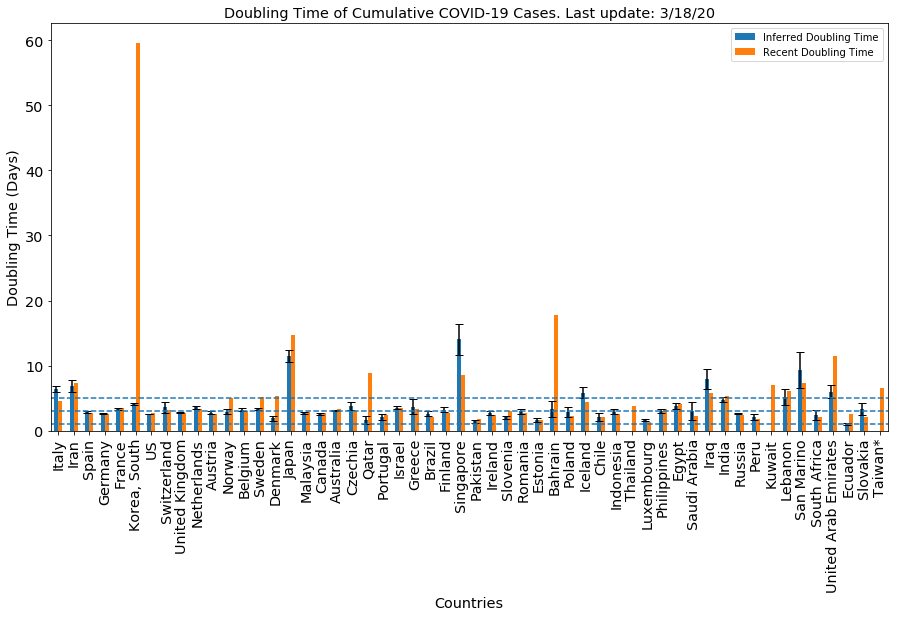

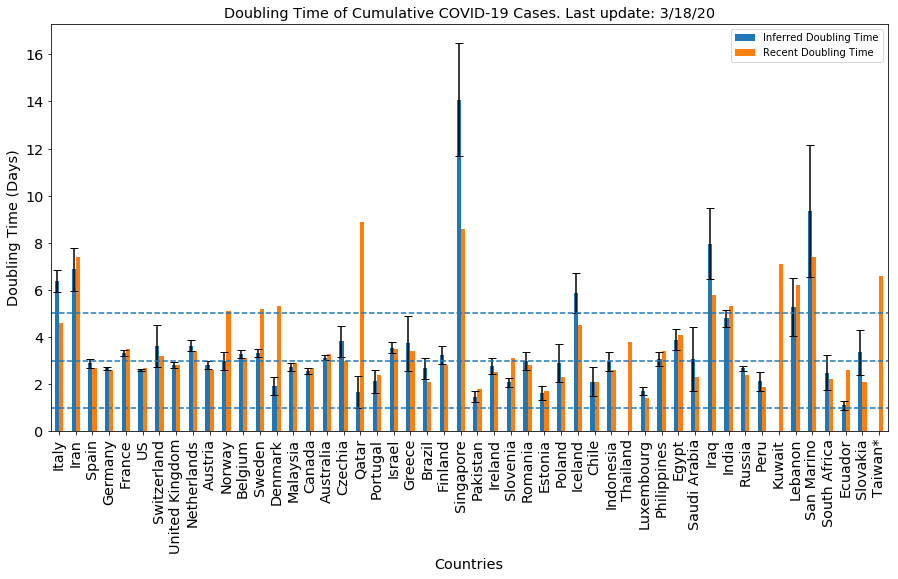

In [6]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [7]:
uscases = df[df['Country/Region'] == 'US'].copy()

# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

for index, row in uscases.iterrows():
    location = row['Province/State']
    try:
        if ',' in location:
            result = [x.strip() for x in location.split(',')]
            statename = states[result[1]]
            row['State'] = statename
            uscases.loc[index, 'Province/State'] = statename
    except:
        print('Error parsing US state:', location)        
            
usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 3/18/20


,3/18/20
Province/State,
New York,2495
Washington,1014
California,751
Florida,314
New Jersey,267
Louisiana,257
Massachusetts,218
Georgia,199
Colorado,184


## Curve Fitting US COVID-19 Cases

                3/18/20
Province/State         
New York           2495
Washington         1014
California          751
Florida             314
New Jersey          267
Louisiana           257
Massachusetts       218
Georgia             199
Colorado            184
Texas               173
Illinois            162
Pennsylvania        152


US state:  New York

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 2495
	Confirmed cases on 3/11/20 	 220
	Ratio: 11.34
	Weekly increase: 1034.1 %
	Daily increase: 41.5 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.993660942305
	Doubling Time (during middle of growth):  3.39 (± 0.38 ) days

** Based on Exponential Fit **

	R^2: 0.993660942392
	Doubling Time (represents overall growth):  1.69 (± 0.16 ) days


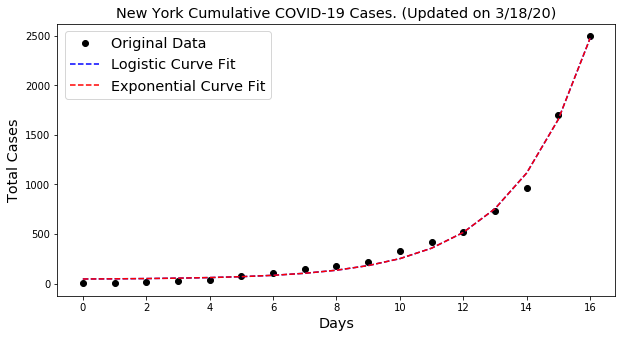



US state:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 1014
	Confirmed cases on 3/11/20 	 366
	Ratio: 2.77
	Weekly increase: 177.0 %
	Daily increase: 15.7 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Exponential Fit **

	R^2: 0.976327005635
	Doubling Time (represents overall growth):  3.79 (± 0.33 ) days


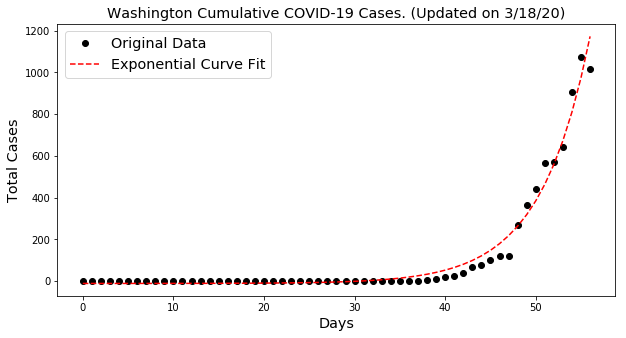



US state:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 751
	Confirmed cases on 3/11/20 	 177
	Ratio: 4.24
	Weekly increase: 324.3 %
	Daily increase: 22.9 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Exponential Fit **

	R^2: 0.99516857533
	Doubling Time (represents overall growth):  3.25 (± 0.13 ) days


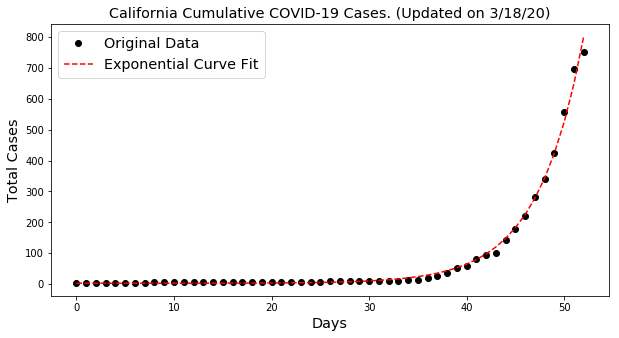



US state:  Florida

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 314
	Confirmed cases on 3/11/20 	 28
	Ratio: 11.21
	Weekly increase: 1021.4 %
	Daily increase: 41.2 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.999266816108
	Doubling Time (during middle of growth):  3.88 (± 0.45 ) days

** Based on Exponential Fit **

	R^2: 0.999263318604
	Doubling Time (represents overall growth):  1.97 (± 0.06 ) days


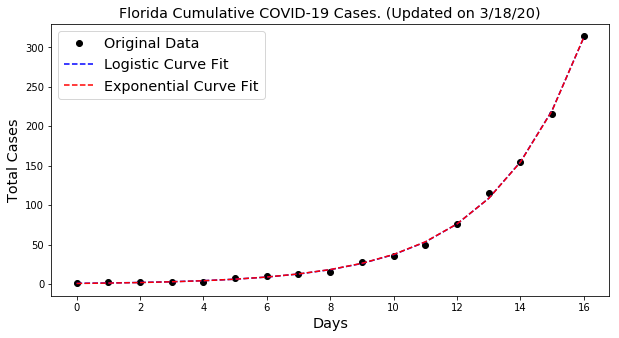



US state:  New Jersey

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 267
	Confirmed cases on 3/11/20 	 23
	Ratio: 11.61
	Weekly increase: 1060.9 %
	Daily increase: 41.9 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.987855408005
	Doubling Time (during middle of growth):  1.4 (± 0.46 ) days

** Based on Exponential Fit **

	R^2: 0.956903223315
	Doubling Time (represents overall growth):  2.26 (± 0.74 ) days


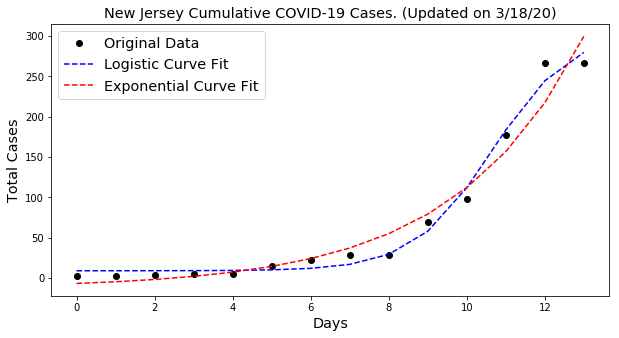



US state:  Louisiana

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 257
	Confirmed cases on 3/11/20 	 6
	Ratio: 42.83
	Weekly increase: 4183.3 %
	Daily increase: 71.0 % per day
	Doubling Time (represents recent growth): 1.3 days

** Based on Logistic Fit**

	R^2: 0.995919434074
	Doubling Time (during middle of growth):  3.41 (± 1.76 ) days

** Based on Exponential Fit **

	R^2: 0.994946542497
	Doubling Time (represents overall growth):  2.49 (± 0.44 ) days


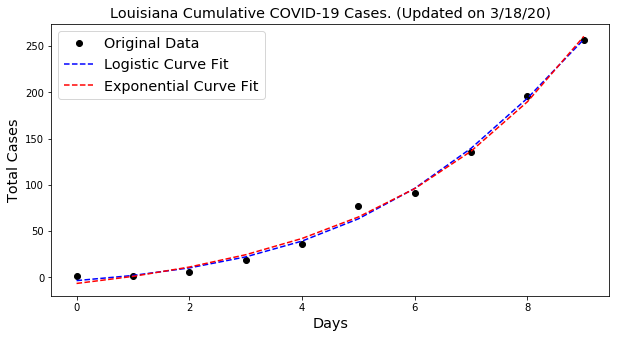



US state:  Massachusetts

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 218
	Confirmed cases on 3/11/20 	 95
	Ratio: 2.29
	Weekly increase: 129.5 %
	Daily increase: 12.6 % per day
	Doubling Time (represents recent growth): 5.8 days

** Based on Exponential Fit **

	R^2: 0.953832913827
	Doubling Time (represents overall growth):  4.03 (± 0.56 ) days


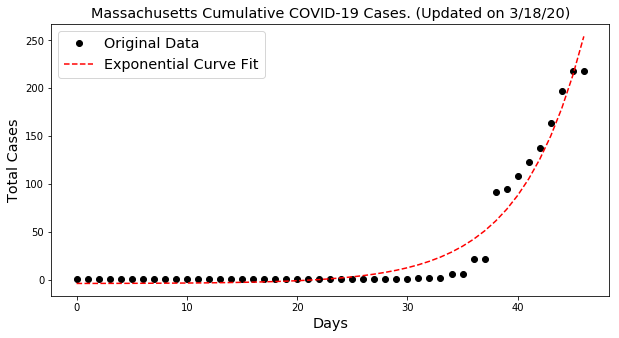



US state:  Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 199
	Confirmed cases on 3/11/20 	 23
	Ratio: 8.65
	Weekly increase: 765.2 %
	Daily increase: 36.1 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.995878044889
	Doubling Time (during middle of growth):  3.62 (± 0.9 ) days

** Based on Exponential Fit **

	R^2: 0.99380998082
	Doubling Time (represents overall growth):  2.61 (± 0.29 ) days


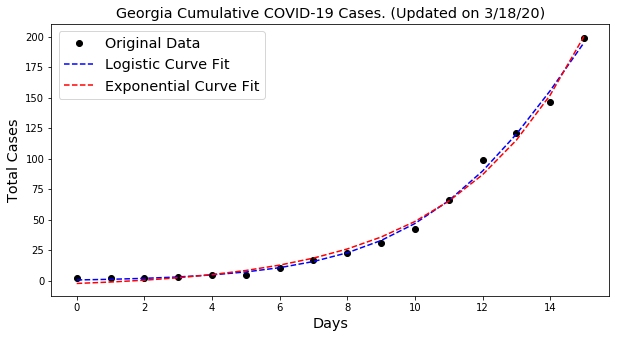



US state:  Colorado

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 184
	Confirmed cases on 3/11/20 	 34
	Ratio: 5.41
	Weekly increase: 441.2 %
	Daily increase: 27.3 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Logistic Fit**

	R^2: 0.989536917161
	Doubling Time (during middle of growth):  1.93 (± 0.61 ) days

** Based on Exponential Fit **

	R^2: 0.958244820337
	Doubling Time (represents overall growth):  5.01 (± 3.04 ) days


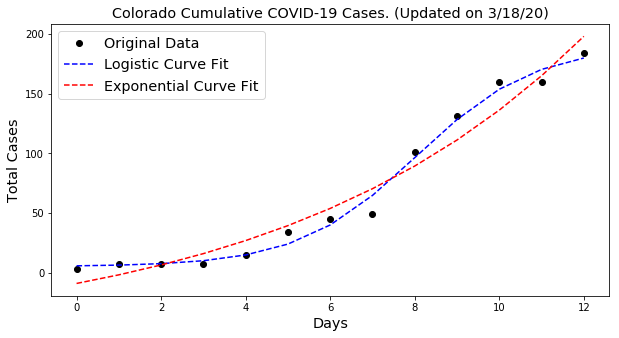



US state:  Texas

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 173
	Confirmed cases on 3/11/20 	 21
	Ratio: 8.24
	Weekly increase: 723.8 %
	Daily increase: 35.2 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.988588480432
	Doubling Time (during middle of growth):  4.58 (± 0.94 ) days

** Based on Exponential Fit **

	R^2: 0.988588480668
	Doubling Time (represents overall growth):  2.29 (± 0.38 ) days


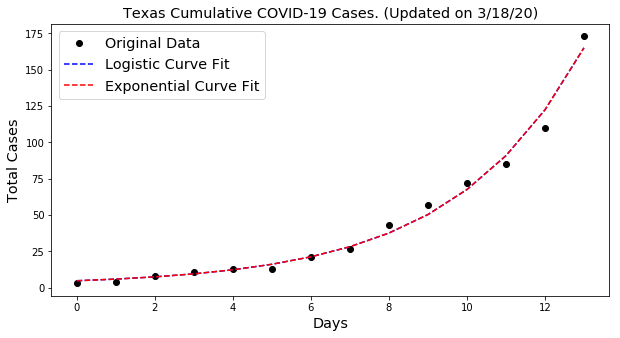



US state:  Illinois

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 162
	Confirmed cases on 3/11/20 	 25
	Ratio: 6.48
	Weekly increase: 548.0 %
	Daily increase: 30.6 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Exponential Fit **

	R^2: 0.980435243812
	Doubling Time (represents overall growth):  2.57 (± 0.2 ) days


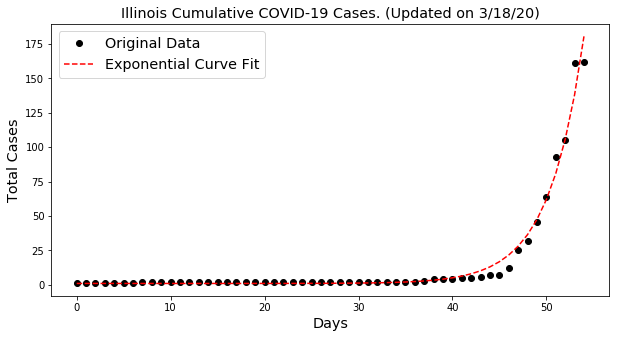



US state:  Pennsylvania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/18/20 	 152
	Confirmed cases on 3/11/20 	 16
	Ratio: 9.5
	Weekly increase: 850.0 %
	Daily increase: 37.9 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.995130169957
	Doubling Time (during middle of growth):  4.96 (± 0.76 ) days

** Based on Exponential Fit **

	R^2: 0.995130170029
	Doubling Time (represents overall growth):  2.48 (± 0.3 ) days


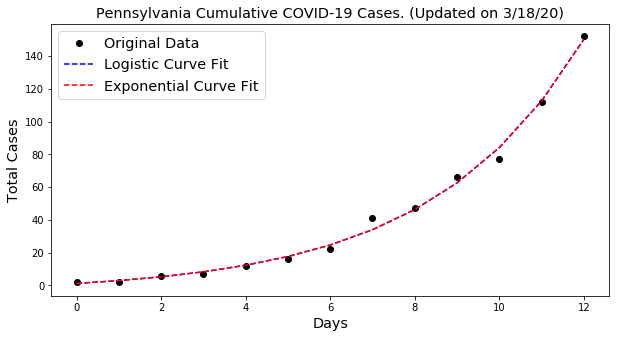

In [8]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for US COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


           States  Inferred Doubling Time  Recent Doubling Time
0        New York                     1.7                   2.0
1      Washington                     3.8                   4.8
2      California                     3.3                   3.4
3         Florida                     2.0                   2.0
4      New Jersey                     1.4                   2.0
5       Louisiana                     3.4                   1.3
6   Massachusetts                     4.0                   5.8
7         Georgia                     3.6                   2.2
8        Colorado                     1.9                   2.9
9           Texas                     2.3                   2.3
10       Illinois                     2.6                   2.6
11   Pennsylvania       

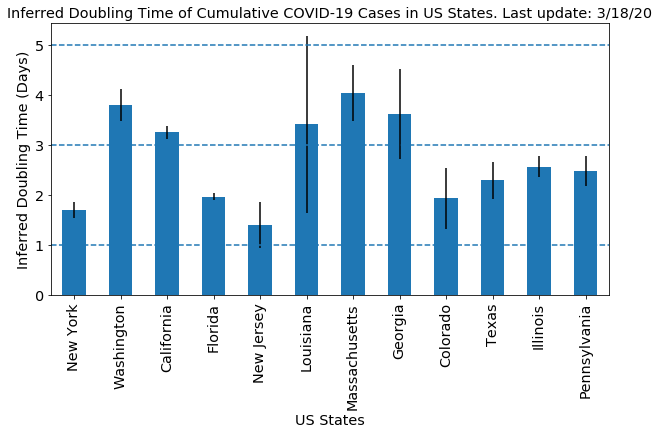

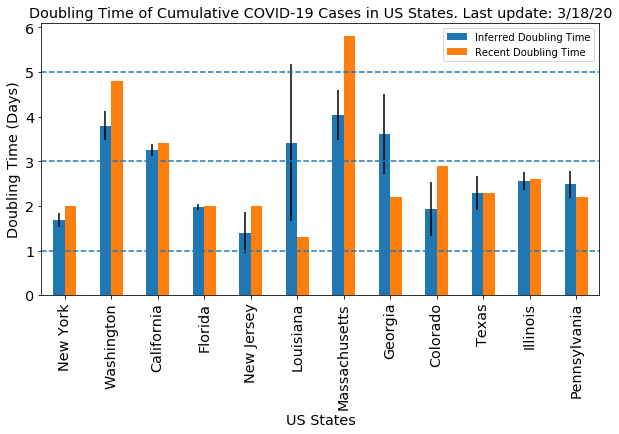

In [9]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).iloc[:,[3,1,2]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=states
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(yerr=err, figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()